In [1]:
# Import

import numpy
import pandas
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.statistics import mean, variance
from harmonica.statistics import weighted_mean, weighted_variance
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

False


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

# Example-01: Model setup

In [3]:
# Model configuration is stored in a yaml format with data for each location (a point of interest)

# DEFAULT CONFIGURATION FILE
# NOTE, HEAD AND TAIL VIRTUAL LOCATIONS SHOULD ALWAYS PRESENT

# LOCATION RECORD
# <NAME>: {TYPE:<TYPE>, FLAG:<FLAG>, JOIN:<JOIN>, RISE:<RISE>, TIME:<TIME>, BX:<BX>, AX:<AX>, FX:<FX>, SIGMA_BX:<SIGMA_BX>, SIGMA_AX:<SIGMA_AX>, SIGMA_FX:<SIGMA_FX>, BY:<BY>, AX:<AY>, FY:<FY>, SIGMA_BY:<SIGMA_BY>, SIGMA_AY:<SIGMA_AY>, SIGMA_FY:<SIGMA_FY>}
# <NAME>:
#   LOCATION NAME
#   HEAD & TAIL ARE SPECIAL VIRTUAL LOCATIONS
# <TYPE>:
#   LOCATION TYPE (VIRTUAL OR MONITOR)
#   MONITOR TYPE SHOULD BE USED FOR LOCATIONS WHERE TBT DATA IS AVALIBLE
#   OTHER LOCATIONS WHERE TBT DATA IS NOT AVALIBLE DIRECTRY SHOULD BE DEFINED AS VIRTUAL
#   FREQUENCY AND OTHER PARAMETERS INFERRED FROM TBT DATA ARE NOT COMPUTED FOR VIRTUAL LOCATIONS
#   IF BPM IS OFF, TYPE IS CHANGED TO VIRTUAL
#   IF BPM IS FLAGGED (E.G. ANOMALY OR SHYNCHRONIZATION ERROR), TYPE IS CHANGED TO VIRTUAL
# <FLAG>:
#   FLAG TO COMPUTE OPTICS (0 OR 1)
# <JOIN>:
#   FLAG TO USE IN MIXED DATA COMPUTAION
# <RISE>:
#   LOCATION RISE
#   STARTING TURN FOR MONITOR LOCATION
# <TIME>:
#   PHYSICAL LOCATION
#   NOTE, ORDERING IS CHECKED BY PHYSICAL LOCATION
# <BX>, <AX>, <FX>, <BY>, <AY>, <FY>
#   UNCOUPLED TWISS PARAMETERS
#   NOTE, PHASE ADVANCE IS DEFIEND FROM HEAD TO LOCATION
# <SIGMA_BX>, <SIGMA_AX>, <SIGMA_FX>, <SIGMA_BY>, <SIGMA_AY>, <SIGMA_FY>
#   MODEL TWISS ERROR AT THE LOCATION AND PHASE ADVANCE ERROR FROM GIVEN LOCATION TO THE NEXT ONE

In [4]:
# Set uncopled Model instance
model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)
model.data_frame

,HEAD,STP2,IV4P,STP4,SRP1,SRP2,SRP3,SRP4,SRP5,SRP6,...,NRP4,NRP3,NRP2,NRP1,NTP4,IV4E,NTP2,NTP0,STP0,TAIL
TYPE,VIRTUAL,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,...,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,VIRTUAL
FLAG,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
JOIN,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
RISE,-1,8,-1,8,8,8,8,8,8,8,...,9,9,9,9,9,-1,9,9,9,-1
TIME,0.0,0.0,4.1535,6.667,10.190565,17.337624,24.484683,31.631742,38.778801,45.92586,...,314.367774,321.514833,328.661892,335.808951,339.332516,341.846016,345.999516,353.307016,358.767516,366.075016
BX,7.467461,7.467461,14.238343,3.121346,4.735711,4.560311,4.48402,4.755363,4.490419,4.552264,...,4.755363,4.48402,4.560311,4.735711,3.121346,14.238343,7.467461,15.068229,15.068229,7.467461
AX,-0.678322,-0.678322,1.955065,0.382216,-0.801359,-0.720007,-0.769987,-0.788485,-0.715242,-0.788853,...,0.788485,0.769987,0.720007,0.801359,-0.382216,-1.955065,0.678322,0.187567,-0.187567,-0.678322
FX,0.0,0.0,0.385863,0.837521,1.965122,3.064451,4.221361,5.333373,6.443944,7.601242,...,45.781099,46.893111,48.050022,49.14935,50.276951,50.72861,51.114472,52.191233,52.562058,53.638818
SIGMA_BX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SIGMA_AX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Main attributes

# yaml file path
# model.path

# model type
# model.model

# model dictionary (yaml file as dictionary)
# model.dict

# model data frame (yaml file as data frame)
# model.data_frame

# model size (total number of locations)
# model.size

# model location names, two special locations ('HEAD' and 'TAIL') should always present
# model.name

# model location type ('MONITOR' or 'VIRTUAL')
# model.kind

# model flag
# model.flag

# model join flag, flag to use location in data mixing
# model.join

# model rise, first turn
# model.rise

# model time, location position
# model.time

# model length, total length, 'TAIL' position
# model.length

# monitor/virtual index, indices of monitor/virtual locations
# model.monitor_index
# model.virtual_index

# number of monitor/virtual locations, 'HEAD' and 'TAIL' included
# model.monitor_count
# model.virtual_count

# monitor/virtual locations names
# model.monitor_name
# model.virtual_name

# twiss parameters for uncoupled model (data type and device are defined on initialization)
# bx/ax/by/ay -- beta and alpha values at the location
# fx/fy -- phase advance from start to the location
# model.bx
# model.ax
# model.fx
# model.by
# model.ay
# model.fy

# twiss parameters (systematic) errors for uncoupled model
# sigma_bx/sigma_ax/sigma_by/sigma_ay -- beta and alpha errors at the location,
# sigma_fx/sigma_fy -- phase advance error from the location to the next one
# model.sigma_bx
# model.sigma_ax
# model.sigma_fx
# model.sigma_by
# model.sigma_ay
# model.sigma_fy

# total phase advance from 'HEAD' to 'TAIL'
# model.mux
# model.muy

# total phase advance error from 'HEAD' to 'TAIL'
# model.sigma_mux
# model.sigma_muy

# tune
# model.nux
# model.nuy

# tune error
# model.sigma_nux
# model.sigma_nuy

# phase advance and error from the location to the next one
# model.phase_x, model.sigma_x
# model.phase_y, model.sigma_y

# phase advance and error from the monitor location to the next monitor location
# model.monitor_phase_x, model.monitor_sigma_x
# model.monitor_phase_y, model.monitor_sigma_y

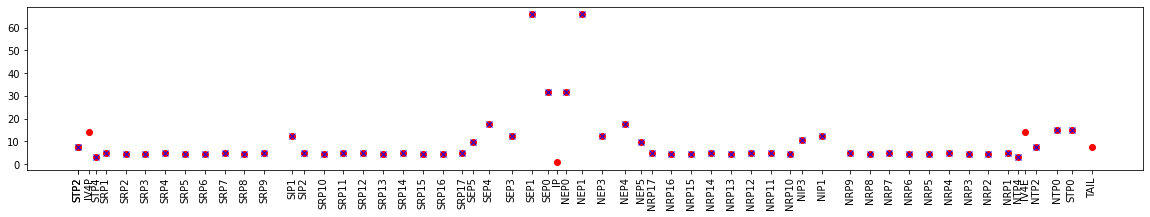

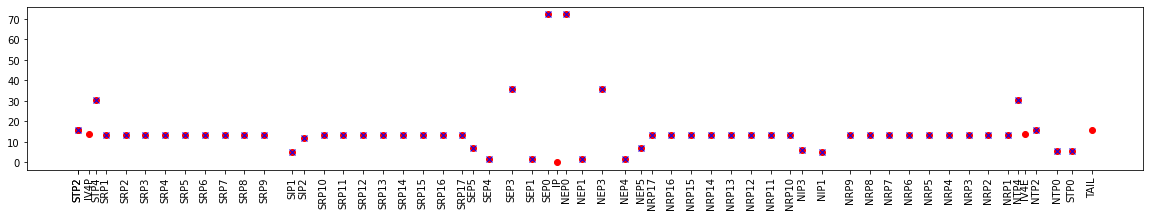

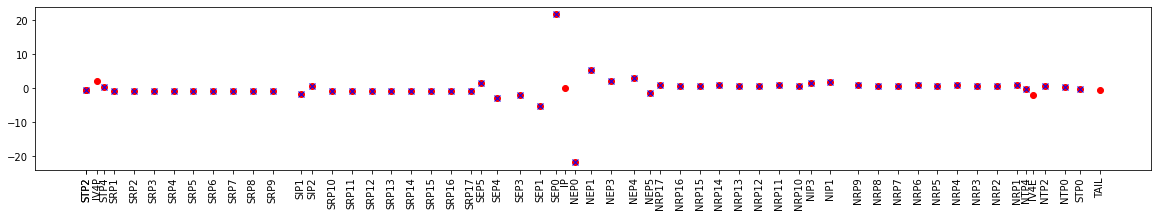

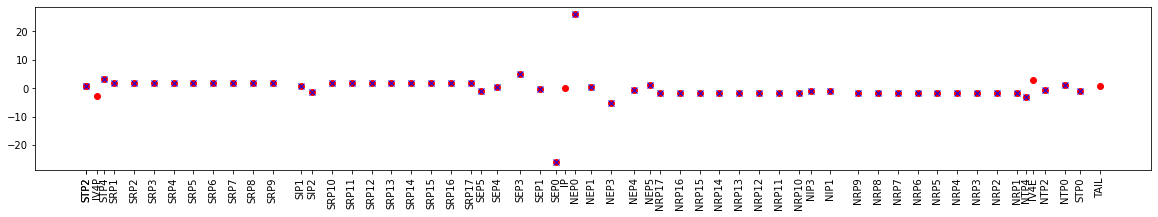

In [6]:
# Plot twiss beta & alpha

# Note, 'HEAD' and 'STP2' locations are at the same position

# bx
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.bx.cpu().numpy(), yerr=model.sigma_bx.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), yerr=model.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# by
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.by.cpu().numpy(), yerr=model.sigma_by.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), yerr=model.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# ax
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.ax.cpu().numpy(), yerr=model.sigma_ax.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.ax[model.monitor_index].cpu().numpy(), yerr=model.sigma_ax[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# ay
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.ay.cpu().numpy(), yerr=model.sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.ay[model.monitor_index].cpu().numpy(), yerr=model.sigma_ay[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

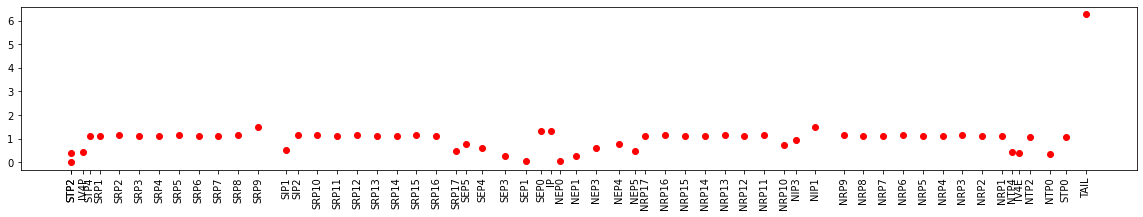

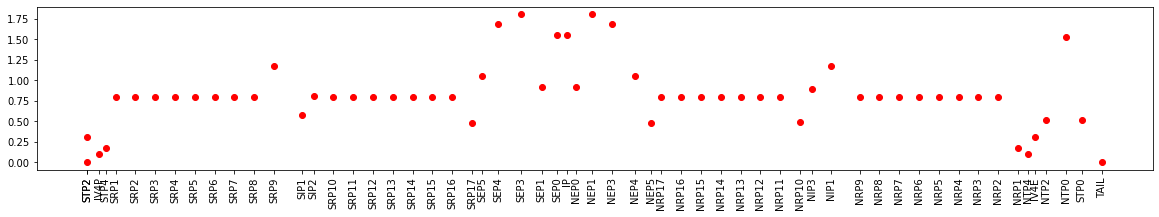

In [7]:
# Plot phase advance between locations

# phase_x
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.phase_x.cpu().numpy(), yerr=model.sigma_x.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# phase_y
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.phase_y.cpu().numpy(), yerr=model.sigma_y.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

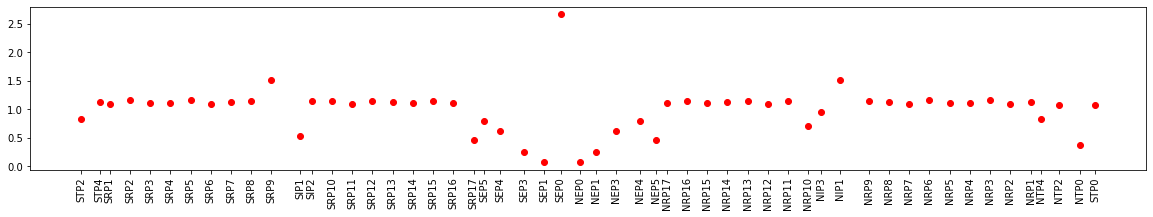

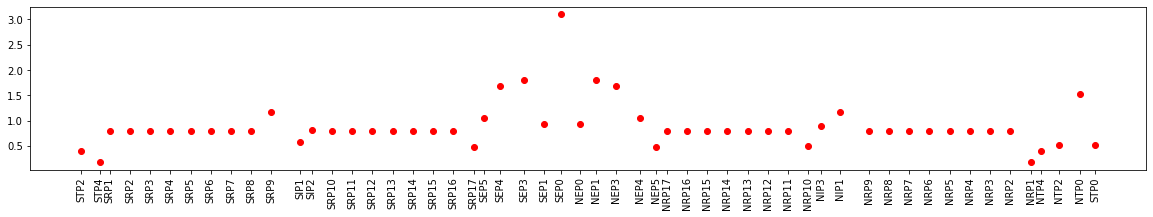

In [8]:
# Plot phase advance between monitor locations

# monitor_phase_x
plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_x.cpu().numpy(), yerr=model.monitor_sigma_x.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# monitor_phase_y
plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_y.cpu().numpy(), yerr=model.monitor_sigma_y.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# Example-02: Table & model setup

In [9]:
# Table class can be used as a container to store TbT parameters
# Frequency, amplitude and phase (including corresponding errors)

In [10]:
# Set uncopled Model instance
model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)
model.data_frame

,HEAD,STP2,IV4P,STP4,SRP1,SRP2,SRP3,SRP4,SRP5,SRP6,...,NRP4,NRP3,NRP2,NRP1,NTP4,IV4E,NTP2,NTP0,STP0,TAIL
TYPE,VIRTUAL,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,...,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,VIRTUAL
FLAG,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
JOIN,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
RISE,-1,8,-1,8,8,8,8,8,8,8,...,9,9,9,9,9,-1,9,9,9,-1
TIME,0.0,0.0,4.1535,6.667,10.190565,17.337624,24.484683,31.631742,38.778801,45.92586,...,314.367774,321.514833,328.661892,335.808951,339.332516,341.846016,345.999516,353.307016,358.767516,366.075016
BX,7.467461,7.467461,14.238343,3.121346,4.735711,4.560311,4.48402,4.755363,4.490419,4.552264,...,4.755363,4.48402,4.560311,4.735711,3.121346,14.238343,7.467461,15.068229,15.068229,7.467461
AX,-0.678322,-0.678322,1.955065,0.382216,-0.801359,-0.720007,-0.769987,-0.788485,-0.715242,-0.788853,...,0.788485,0.769987,0.720007,0.801359,-0.382216,-1.955065,0.678322,0.187567,-0.187567,-0.678322
FX,0.0,0.0,0.385863,0.837521,1.965122,3.064451,4.221361,5.333373,6.443944,7.601242,...,45.781099,46.893111,48.050022,49.14935,50.276951,50.72861,51.114472,52.191233,52.562058,53.638818
SIGMA_BX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SIGMA_AX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Load test data
data = pandas.read_pickle('../virtual_tbt.pkl.gz')

data_x = torch.tensor(data.X.to_list(), dtype=dtype, device=device)
data_y = torch.tensor(data.Y.to_list(), dtype=dtype, device=device)

# Set noise sigma for each BPM and plane
noise_x = 1.0E-6*(25.0 + 75.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 75.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

nux= 0.536883099, sigma_nux=1.36613877e-16
nux= 0.536883555, sigma_nux=1.25091735e-06, error=4.55811435e-07
nux= 0.536883362, sigma_nux=7.52897353e-07, error=2.63582096e-07


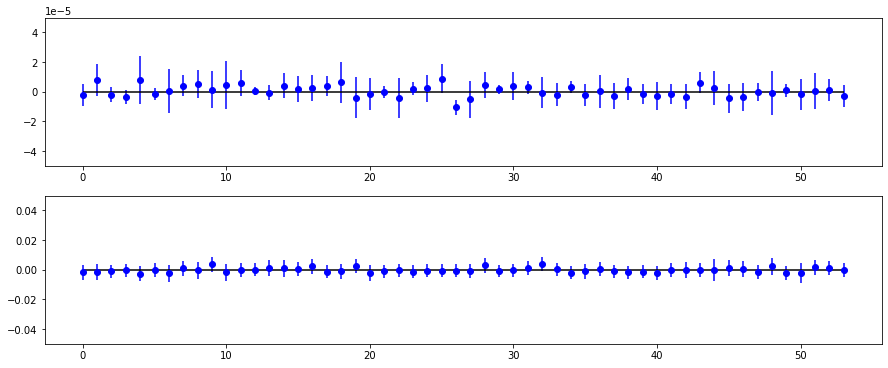

In [12]:
# Compute parameters for x plane

# Reference parameters
length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)
d = Data.from_data(w, data_x[:, :length])
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = mean(f.frequency), variance(f.frequency).sqrt()
frequency = 1.0 - frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, ref_ax, ref_fx = result.T
print(f'nux={frequency.item():12.9}, sigma_nux={spread.item():12.9}')

# Frequency
length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, data_x[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)
l = Filter(d)
_, s = l.estimate_noise(limit=32)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
w = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2
nux, sigma_nux = weighted_mean(f.frequency), weighted_variance(f.frequency).sqrt()
nux = 1.0 - nux
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error={abs(frequency-nux).item():12.9}')
nux, sigma_nux = weighted_mean(f.frequency, weight=w), weighted_variance(f.frequency, weight=w).sqrt()
nux = 1.0 - nux
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error={abs(frequency-nux).item():12.9}')

# Amplitude
dec = Decomposition(d)
ax, sigma_ax, _ = dec.harmonic_amplitude(nux, length=128, order=1.0, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')

# Phase
dec = Decomposition(d)
fx, sigma_fx, _ = dec.harmonic_phase(nux, length=256, order=0.0, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-5.0E-2, +5.0E-2)
plt.show()

nux= 0.576774633, sigma_nux=2.00293495e-16
nux= 0.576774757, sigma_nux=1.35856707e-06, error=1.23214783e-07
nux= 0.576774711, sigma_nux=6.07194424e-07, error=7.79482399e-08


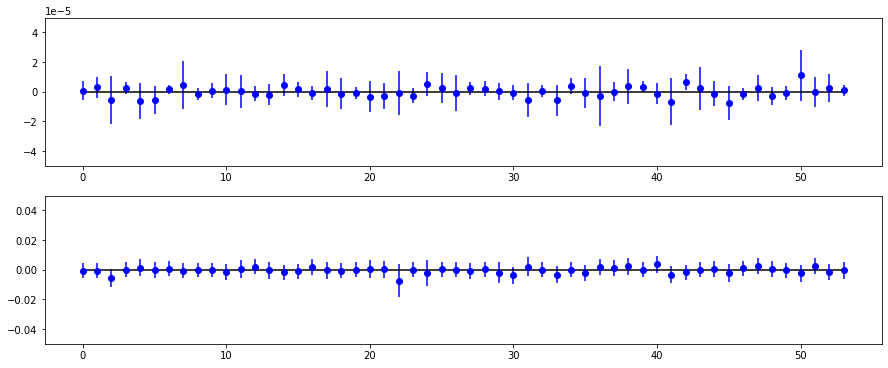

In [13]:
# Compute parameters for y plane

# Reference parameters
length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)
d = Data.from_data(w, data_y[:, :length])
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = mean(f.frequency), variance(f.frequency).sqrt()
frequency = 1.0 - frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, ref_ay, ref_fy = result.T
print(f'nux={frequency.item():12.9}, sigma_nux={spread.item():12.9}')

# Frequency
length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, data_y[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)
l = Filter(d)
_, s = l.estimate_noise(limit=32)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
w = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2
nuy, sigma_nuy = weighted_mean(f.frequency), weighted_variance(f.frequency).sqrt()
nuy = 1.0 - nuy
print(f'nux={nuy.item():12.9}, sigma_nux={sigma_nuy.item():12.9}, error={abs(frequency - nuy).item():12.9}')
nuy, sigma_nuy = weighted_mean(f.frequency, weight=w), weighted_variance(f.frequency, weight=w).sqrt()
nuy = 1.0 - nuy
print(f'nux={nuy.item():12.9}, sigma_nux={sigma_nuy.item():12.9}, error={abs(frequency - nuy).item():12.9}')

# Amplitude
dec = Decomposition(d)
ay, sigma_ay, _ = dec.harmonic_amplitude(nuy, length=128, order=1.0, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')

# Phase
dec = Decomposition(d)
fy, sigma_fy, tmp = dec.harmonic_phase(nuy, length=256, order=0.0, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-5.0E-2, +5.0E-2)
plt.show()

In [14]:
# Set Table instance
table = Table(model.monitor_name, nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)
table

Table(54)

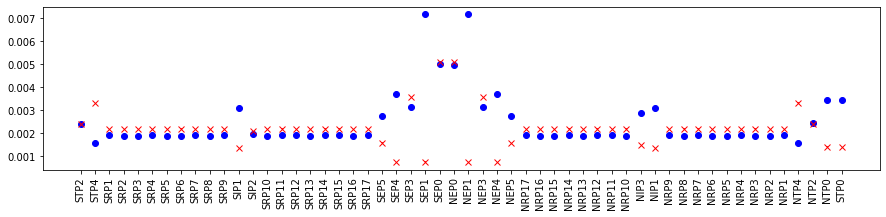

In [15]:
# Plot amplitude
plt.figure(figsize=(15, 3))
plt.errorbar(range(table.size), table.ax.cpu().numpy(), yerr=table.sigma_ax.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(range(table.size), table.ay.cpu().numpy(), yerr=table.sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.xticks(range(table.size), table.name)
locs, labs = plt.xticks()
plt.setp(labs, rotation=90)
plt.show()

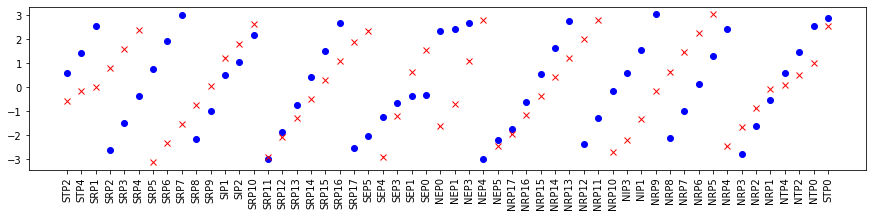

In [16]:
# Plot phase
plt.figure(figsize=(15, 3))
plt.errorbar(range(table.size), table.fx.cpu().numpy(), yerr=table.sigma_fx.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(range(table.size), table.fy.cpu().numpy(), yerr=table.sigma_fy.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.xticks(range(table.size), table.name)
locs, labs = plt.xticks()
plt.setp(labs, rotation=90)
plt.show()

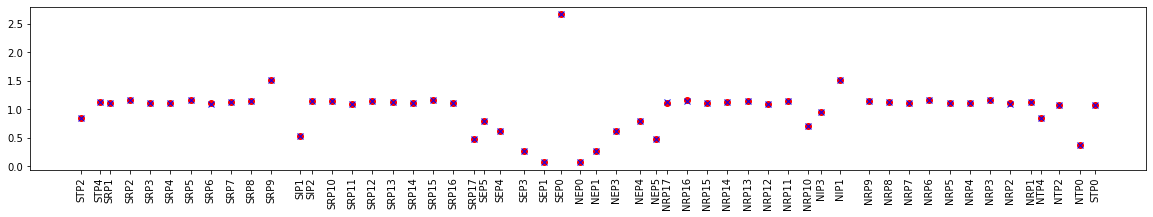

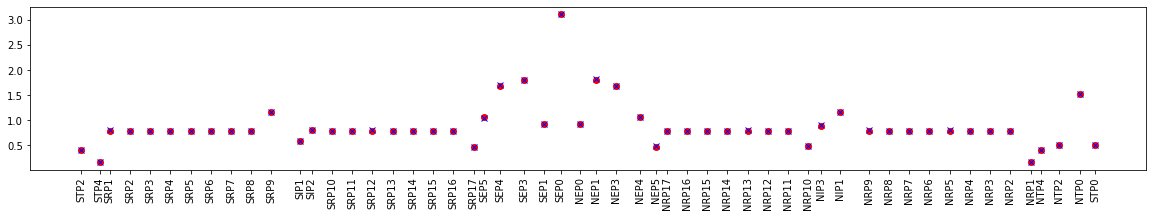

In [17]:
# Plot phase advance between monotors and compare with model

# Note, phase advance is mod two pi is both cases

# x
plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_x.cpu().numpy(), yerr=model.monitor_sigma_x.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), table.phase_x.cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# y
plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_y.cpu().numpy(), yerr=model.monitor_sigma_y.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), table.phase_y.cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()